In [21]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file\n",
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

In [22]:
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate

In [23]:
justice_dict = {}
justices = ["John G. Roberts, Jr.", "Clarence Thomas", "Samuel A. Alito, Jr.", "Sonia Sotomayor",
            "Elena Kagan", "Neil M. Gorsuch", "Brett M. Kavanaugh", "Amy Coney Barrett", "Ketanji Brown Jackson"]

In [24]:
# This is an LLMChain to define the justice
# llm = OpenAI(temperature=.8)
llm=ChatOpenAI(model_name = "gpt-4", temperature=0)
synopsis_template = """You are Supreme Court Justice {name},. \n
When presented with a legal question, you will respond with a legal opinion based on your interpretation of the law as {name} would.

Question: {question}
Supreme Court Justice: This is my legal opinion on the above question:"""
synopsis_prompt_template = PromptTemplate(input_variables=["name", "question"], template=synopsis_template)
synopsis_chain = LLMChain(llm=llm, prompt=synopsis_prompt_template, output_key="opinion")

In [25]:
# This is an LLMChain to characterize the opinion 
llm = OpenAI(temperature=.2)
template = """You accept take a legal question and legal opinion and interpret the opinion as being 'In Favor', 'Against', or 'Undecided'.

Question: {question}
Legal Opinion: {opinion}
Interpretation of the above opinion:"""

prompt_template = PromptTemplate(input_variables=["question", "opinion"], template=template)
review_chain = LLMChain(llm=llm, prompt=prompt_template, output_key="interpretation")

In [26]:
# This is the overall chain where we run these two chains in sequence.
from langchain.chains import SequentialChain
overall_chain = SequentialChain(
    chains=[synopsis_chain, review_chain], 
    input_variables=["name", "question"],
    # Here we return multiple variables
    output_variables=["opinion", "interpretation"],
    verbose=False)

In [27]:
def encode_output(output):
    mapping = {"In Favor": 1, "Against": -1, "Undecided": 0}
    return mapping.get(output, "Invalid output")

In [28]:
def make_the_call(justice, iterations):
    rulings = []
    for i in range(1, iterations):
        ruling = overall_chain({"name":justice, "question": "Does the US constitution support the notion that there is a constitutional right to abortion?"})
        rulings.append(encode_output(ruling['interpretation'].strip()))
    print(rulings)
    return [justice, rulings]

In [29]:
# Initialize a Counter for each category
counts = {0: [], 1: [], -1: []}

# Get the counts for each justice
for justice in justices:
    rulings = make_the_call(justice, 12)
    for ruling in [0, 1, -1]:
        counts[ruling].append(rulings[1].count(ruling))  # Count from rulings[1]

[0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[0, -1, -1, 0, -1, -1, -1, -1, -1, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, -1, 0, 0, 0, -1, 0, -1, -1, 0, 0]
[1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]


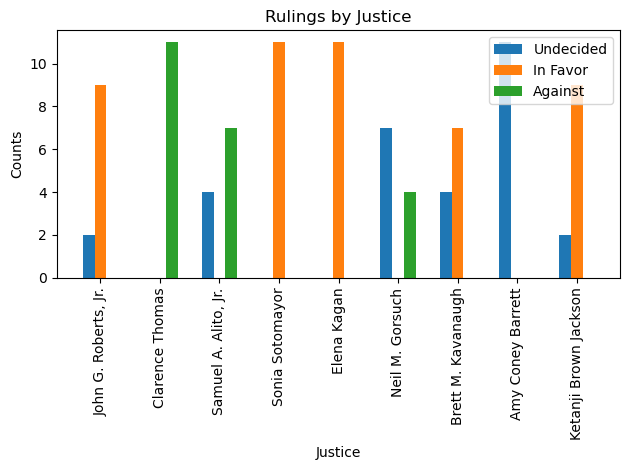

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Set up the plot
x = np.arange(len(justices))
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, counts[0], width, label='Undecided')
rects2 = ax.bar(x, counts[1], width, label='In Favor')
rects3 = ax.bar(x + width, counts[-1], width, label='Against')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Justice')
ax.set_ylabel('Counts')
ax.set_title('Rulings by Justice')
ax.set_xticks(x)
ax.set_xticklabels(justices, rotation=90)
ax.legend()

fig.tight_layout()
plt.show()